In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mgodgildieva","key":"0ec04c184ef0a393b7f9788459b64152"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/

In [7]:
!mkdir comment_data

In [8]:
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p comment_data

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 46.8MB/s]
 65% 17.0M/26.3M [00:00<00:00, 25.4MB/s]
100% 26.3M/26.3M [00:00<00:00, 36.1MB/s]
 21% 5.00M/23.4M [00:00<00:00, 20.3MB/s]
100% 23.4M/23.4M [00:00<00:00, 67.5MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 47.7MB/s]


In [10]:
! unzip comment_data/train.csv.zip -d comment_data
! unzip comment_data/test.csv.zip -d comment_data
! unzip comment_data/test_labels.csv.zip -d comment_data
! unzip comment_data/sample_submission.csv.zip -d comment_data

Archive:  comment_data/train.csv.zip
  inflating: comment_data/train.csv  
Archive:  comment_data/test.csv.zip
  inflating: comment_data/test.csv   
Archive:  comment_data/test_labels.csv.zip
  inflating: comment_data/test_labels.csv  
Archive:  comment_data/sample_submission.csv.zip
  inflating: comment_data/sample_submission.csv  


In [11]:
! rm comment_data/train.csv.zip comment_data/test.csv.zip comment_data/sample_submission.csv.zip 

In [12]:
! rm comment_data/test_labels.csv.zip comment_data/sample_submission.csv 

### EDA

In [13]:
import pandas as pd
import numpy as np
import gc
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
train = pd.read_csv('comment_data/train.csv')
print(train.shape)
train.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
test = pd.read_csv('comment_data/test.csv')
print(test.shape)
test.head()

(153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [16]:
test_labels = pd.read_csv('comment_data/test_labels.csv')
print(test_labels.shape)
test_labels.head()

(153164, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [17]:
test_labels = test_labels[test_labels.toxic!=-1]
test = test.merge(test_labels, on=['id'])
print(test.shape)
test.head()

(63978, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [18]:
test.to_csv('comment_data/labelled_test.csv', index=None)
del test_labels
gc.collect()

106

In [19]:
test = pd.read_csv('comment_data/labelled_test.csv')

In [20]:
train.drop(['id', 'comment_text'], axis=1).apply(pd.Series.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [21]:
test.drop(['id', 'comment_text'], axis=1).apply(pd.Series.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,57888,63611,60287,63767,60551,63266
1,6090,367,3691,211,3427,712


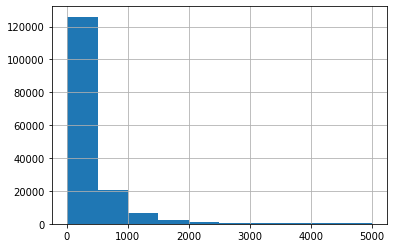

In [22]:
train['comment_text'].apply(len).hist()
plt.show()

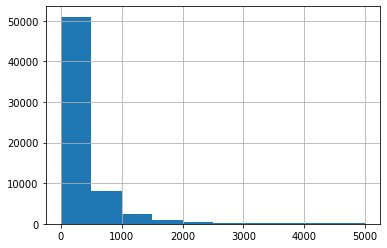

In [23]:
test['comment_text'].apply(len).hist()
plt.show()

### text cleaning

In [24]:
import re
import string

In [25]:
def clean_text(comment):
    comment = comment.lower()
    comment = re.sub('[%s]' % re.escape(string.punctuation), '', comment)
    comment = re.sub('\n', ' ', comment)
    comment = re.sub('\d', '', comment)
    return comment

In [26]:
ex = train.iloc[0].comment_text
ex

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [27]:
clean_text(ex)

'explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now'

In [28]:
train['clean_text'] = train.comment_text.apply(clean_text)
test['clean_text'] = test.comment_text.apply(clean_text)

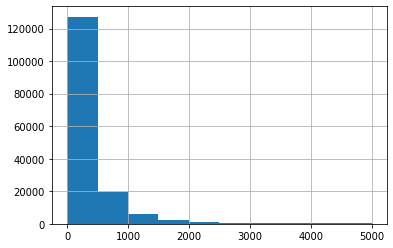

In [29]:
train['clean_text'].apply(len).hist()
plt.show()

In [30]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [31]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [32]:
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

def process_text(comment, lemmatizer=lemmatizer, stopwords=stopwords):
    tokens = word_tokenize(comment)
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]

In [33]:
train['tokens'] = train.clean_text.apply(process_text)
test['tokens'] = test.clean_text.apply(process_text)

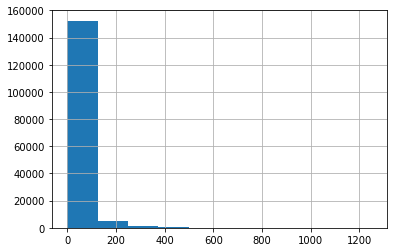

In [34]:
train['tokens'].apply(len).hist()
plt.show()

In [35]:
train = train[train.tokens.apply(len)>0]
#test len(0) -> predict all 0s

In [36]:
from nltk import FreqDist

In [37]:
freq = FreqDist(train.tokens.explode().values)
print(len(freq))
freq.most_common(10)

217726


[('article', 72951),
 ('page', 56483),
 ('wikipedia', 35662),
 ('talk', 31415),
 ('one', 29929),
 ('please', 29614),
 ('would', 29212),
 ('like', 28129),
 ('dont', 25735),
 ('see', 21692)]

In [38]:
train['preprocessed_text'] = train.tokens.apply(lambda x: ' '.join(x))
test['preprocessed_text'] = test.tokens.apply(lambda x: ' '.join(x))

In [39]:
!pip install tensorflow

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.random import set_seed
set_seed(0)

In [41]:
MAX_LEN=100

In [42]:
#encode training and test sets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.preprocessed_text)
train_sequences = tokenizer.texts_to_sequences(train.preprocessed_text)
test_sequences = tokenizer.texts_to_sequences(test.preprocessed_text)

word_index = tokenizer.word_index
#1-hot encoding for labels
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
#make all sequences of the same length
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN)

In [67]:
y_test = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [43]:
DIM=300

In [44]:
!pip install gensim

In [45]:
from gensim.models import KeyedVectors

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
fasttext_emb = KeyedVectors.load_word2vec_format('drive/MyDrive/Colab Notebooks/toxic_challenge/wiki.en.vec')

In [53]:
embedding_matrix = np.zeros((len(word_index)+1, DIM))
for word, i in word_index.items():
    try:
        embedding_matrix[i] = fasttext_emb[word]
    except:
        continue

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
#separate validation set
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_tr.shape, X_val.shape

((127620, 100), (31906, 100))

In [62]:
#early stopping, reduce learning rate
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=10),
         ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)]

#model architecture (LSTM based): 
model_lstm = Sequential()
model_lstm.add(Embedding(embedding_matrix.shape[0], DIM ,input_length=MAX_LEN,weights=[embedding_matrix],trainable=False))
model_lstm.add(Bidirectional(LSTM(DIM, return_sequences=False)))
model_lstm.add(Dense(128,activation="relu"))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(y_train.shape[1],activation="sigmoid"))

model_lstm.compile(optimizer="adam",loss="binary_crossentropy",metrics='accuracy')
history_lstm = model_lstm.fit(X_tr, y_tr, batch_size = 512, epochs=10, validation_data = (X_val, y_val), callbacks=callbacks_list, verbose=True)

Epoch 1/10
250/250 [==============================] - 93s 357ms/step - loss: 0.0860 - accuracy: 0.8437 - val_loss: 0.0593 - val_accuracy: 0.9943
Epoch 2/10
250/250 [==============================] - 88s 353ms/step - loss: 0.0539 - accuracy: 0.9571 - val_loss: 0.0505 - val_accuracy: 0.9943
Epoch 3/10
250/250 [==============================] - 88s 354ms/step - loss: 0.0500 - accuracy: 0.9638 - val_loss: 0.0478 - val_accuracy: 0.9700
Epoch 4/10
250/250 [==============================] - 88s 353ms/step - loss: 0.0469 - accuracy: 0.9669 - val_loss: 0.0455 - val_accuracy: 0.9902
Epoch 5/10
250/250 [==============================] - 88s 353ms/step - loss: 0.0446 - accuracy: 0.9699 - val_loss: 0.0452 - val_accuracy: 0.9937
Epoch 6/10
250/250 [==============================] - 88s 354ms/step - loss: 0.0428 - accuracy: 0.9805 - val_loss: 0.0451 - val_accuracy: 0.9934
Epoch 7/10
250/250 [==============================] - 88s 353ms/step - loss: 0.0409 - accuracy: 0.9802 - val_loss: 0.0440 - val_ac

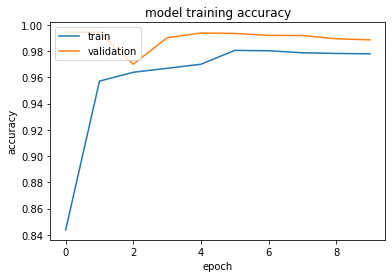

In [65]:
#plot training/validation acc
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [68]:
model_lstm.evaluate(X_test, y_test)

2000/2000 [==============================] - 52s 26ms/step - loss: 0.0707 - accuracy: 0.9872


[0.07072015851736069, 0.9871987104415894]

In [70]:
pred = model_lstm.predict(X_test)
pred.shape

(63978, 6)

In [77]:
pred_thr = (pred>0.5).astype(int)

In [78]:
pred_thr[100]

array([0, 0, 0, 0, 0, 0])

In [80]:
y_test.values[100]

array([0, 0, 0, 0, 0, 0])

In [90]:
errors = (pred_thr!=y_test.values).sum(axis=1).nonzero()

In [92]:
len(errors[0])

7641

In [102]:
for i in range(5):
  idx = errors[0][i]
  print('Text: \n', test.iloc[idx].comment_text)
  print('Predicted: \n', pred_thr[idx])
  print('True labels: \n', y_test.iloc[idx])
  print('========\n')

Text: 
 :Dear god this site is horrible.
Predicted: 
 [1 0 0 0 0 0]
True labels: 
 toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64

Text: 
 :Fuck off, you anti-semitic cunt.  |
Predicted: 
 [1 0 1 0 1 1]
True labels: 
 toxic            1
severe_toxic     0
obscene          1
threat           0
insult           1
identity_hate    0
Name: 29, dtype: int64

Text: 
 ::No, he is an arrogant, self serving, immature idiot. Get it right.
Predicted: 
 [1 0 0 0 1 0]
True labels: 
 toxic            1
severe_toxic     0
obscene          1
threat           0
insult           1
identity_hate    0
Name: 40, dtype: int64

Text: 
 " 

 == Shameless Canvass == 

 Hello, Diannaa! Thanks for blocking that horrible puke again. When I ""translate""  on your page I get mad. He is just a total piece of garbage. Thanks again!   "
Predicted: 
 [1 0 0 0 1 0]
True labels: 
 toxic            0
severe_toxic     0
obscene        